# Toy Model V2.0
## with 2 functional groups & Silicate
## and comparison of model to data
This size based model variant calculates structural changes of a community
composed by n number of morphologically different phytoplankton.

adapted from Estebans PhytoSFDM Model formulation (the full model)

#ToDo:
- Progress Report: Draw Up model structure, preliminary results plotted with data 2,3 pages writing, on slack + small presentation @ group meeting

# initialisation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# ExtractEnvFor:
import scipy.interpolate as intrp
import matplotlib as mpl
import time
import pandas

# Interpolation and setting up EnvForcing

In [2]:
def firstderivspl(Forcing, time, k=3, s=None):
    """
    Method to calculate the first derivative of an interpolated spline.

    Parameters
    ----------
    time: in days
    kind: the type of interpolation either linear, cubic, spline or
           piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The first derivative of the temporally interpolated environmental forcing spline.
    """
    outForcing = Forcing  # spatialave(Forcing)
    tmonth = np.linspace(0., 365., 13) #HERE deprecation warning due to 13. <- float, should be int
    newt = np.mod(time, 365.)
    outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
    return outintp.derivative()(newt)

def dailyinterp(Forcing, time, kind='spline', k=3, s=None):
    """
    Method to interpolate from monthly to daily environmental data.

    Parameters
    -----
    time: in days
    kind: the type of interpolation either linear, cubic, spline or piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The temporally interpolated environmental forcing.
    """
    outForcing = Forcing  # spatialave(Forcing)

    tmonth = np.linspace(0., 12., 13) #HERE again, deprecation warning
    newt = np.mod(time, 365.) * 12. / 365.
    if kind == 'spline':
        outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
        return outintp(newt)
    elif kind == 'PWPoly':
        outintp = intrp.PchipInterpolator(tmonth, outForcing)
        return outintp(newt)
    else:
        outintp = intrp.interp1d(tmonth, outForcing, kind=kind)
        return outintp(newt)

In [3]:
# parameters for interpolation
kmld = 3
smld = 0
kindmld = "spline"
kn0x = 5
sn0x = None
kindn0x = "spline"
kpar = 5
spar = None
kindpar = "spline"
ksst = 5
ssst = None
kindsst = "spline"
ksi0x = 5
ssi0x = None
kindsi0x = "spline"

# params
alphaG = -0.75
kappa = 0.1
muZ = 1.35
moZ = 0.3
deltaZ = 0.31
deltaD = 0.1
betaU = 0.14275
alphaU = -0.75

betav = 0.01989
alphav = 1.17
muP = 1.5
moP = 0.05

Kp = 0.1
kw = 0.1
OptI = 30.

In [4]:
# read environmental forcings
MLDfile = pandas.read_csv('CARIACO_forcing01/MLD')
MLD = list(MLDfile['press'])
MLD.append(MLDfile['press'][0])

NOXfile = pandas.read_csv('CARIACO_forcing01/N0')
NOX = list(NOXfile['as.numeric(NO3_NO2)'])
NOX.append(NOXfile['as.numeric(NO3_NO2)'][0])

SSTfile = pandas.read_csv('CARIACO_forcing01/SST')
SST = list(SSTfile['temp'])
SST.append(SSTfile['temp'][0])

PARfile = pandas.read_csv('CARIACO_forcing01/PAR')
PAR = list(PARfile['value'])
PAR.append(PARfile['value'][0])

SiOXfile = pandas.read_csv('CARIACO_forcing01/Si0')
SiOX = list(SiOXfile['as.numeric(Silicate)'])
SiOX.append(SiOXfile['as.numeric(Silicate)'][0])



# Actual Model

In [5]:
def fullmodelSiNo(x, t):
    N = x[0]
    Si = x[3+NoMtypeSi]
    Z = x[1]
    D = x[2]
    Ps = x[3:3+NoMtypeSi]
    Pn = x[3+NoMtypeSi+1:3+NoMtypeSi+1+NoMtypeNo]
    dxdt = np.zeros(len(x))

    sizerangeSi = np.linspace(np.log(sizeminSi), np.log(sizemaxSi), num=NoMtypeSi)
    sizerangeNo = np.linspace(np.log(sizeminNo), np.log(sizemaxNo), num=NoMtypeNo)

    # Edible phytoplankton
    Ped = np.sum(Ps * np.exp(sizerangeSi) ** alphaG + Pn * np.exp(sizerangeNo) ** alphaG)

    # Non-P Processes
    Mixing = (kappa + max(firstderivspl(MLD, t, k=kmld, s=smld), 0.)) / dailyinterp(MLD, t, kind=kindmld, k=kmld,
                                                                                    s=smld)
    ZooMortality = moZ * Z ** 2
    ZooMixing = Z * firstderivspl(MLD, t, k=kmld, s=smld) / dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)
    Mineralization = deltaD * D
    DetritusMixing = D * (kappa + max(firstderivspl(MLD, t, k=kmld, s=smld), 0.)) / dailyinterp(MLD, t, kind=kindmld,
                                                                                                k=kmld, s=smld)
    NMixing = Mixing * (dailyinterp(NOX, t, kind=kindn0x, k=kn0x, s=sn0x) - N)
    SiMixing = Mixing * (dailyinterp(SiOX, t, kind=kindsi0x, k=ksi0x, s=ssi0x) - Si)
    
    dxdt[0] = Mineralization + NMixing
    dxdt[1] = - ZooMortality - ZooMixing
    dxdt[2] = ZooMortality - Mineralization - DetritusMixing

    for i in range(len(Ps)):
        Ssi = sizerangeSi[i]
        Psi = Ps[i]
        
        
        # Gains of phytoplankton biomass
        N_Uptake = N / (N + betaU * np.exp(Ssi) ** alphaU)
        
        Si_Uptake = Si / (Si + betaU * np.exp(Ssi) ** alphaU)
        
        LightHarvesting = 1. / (kw * dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)) * (
                    -np.exp(1. - dailyinterp(PAR, t, kind=kindpar, k=kpar, s=spar)
                            / OptI) - (-np.exp((1. - (dailyinterp(PAR, t, kind=kindpar, k=kpar, s=spar) * np.exp(-kw *
                            dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld))) / OptI))))
        TemperatureDepGrowth = np.exp(0.063 * dailyinterp(SST, t, kind=kindsst, k=ksst, s=ssst))
        GainsSi = muP * min(N_Uptake,Si_Uptake) * LightHarvesting * TemperatureDepGrowth
        
        # Losses of phytoplankton biomass
        Grazing = muZ * Z * np.exp(Ssi) ** alphaG / (Ped + Kp)
        Sinking = (betav * np.exp(Ssi) ** alphav) / dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)
        OtherPMortalities = moP
        Losses = Grazing + Sinking + OtherPMortalities + Mixing
        # Other Processes
        ZooGrowth = deltaZ * Grazing * Psi
        UnassimilatedProduction = (1. - deltaZ) * Grazing * Psi

        dxdt[0] = dxdt[0] - Psi * GainsSi
        dxdt[1] = dxdt[1] + ZooGrowth
        dxdt[2] = dxdt[2] + UnassimilatedProduction + Psi * OtherPMortalities
        dxdt[3 + i] = Psi * (GainsSi - Losses)
        
        
    for i in range(len(Pn)):
        Sno = sizerangeN[i]
        Pno = Pn[i]
        
        # Gains of phytoplankton biomass
        N_Uptake = N / (N + betaU * np.exp(Sno) ** alphaU)
        
        Si_Uptake = Si / (Si + betaU * np.exp(Sno) ** alphaU)
        
        LightHarvesting = 1. / (kw * dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)) * (
                    -np.exp(1. - dailyinterp(PAR, t, kind=kindpar, k=kpar, s=spar)
                            / OptI) - (-np.exp((1. - (dailyinterp(PAR, t, kind=kindpar, k=kpar, s=spar) * np.exp(-kw *
                            dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld))) / OptI))))
        TemperatureDepGrowth = np.exp(0.063 * dailyinterp(SST, t, kind=kindsst, k=ksst, s=ssst))
        GainsNo = muP * N_Uptake * LightHarvesting * TemperatureDepGrowth

        # Losses of phytoplankton biomass
        Grazing = muZ * Z * np.exp(Sno) ** alphaG / (Ped + Kp)
        Sinking = (betav * np.exp(Sno) ** alphav) / dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)
        OtherPMortalities = moP
        Losses = Grazing + Sinking + OtherPMortalities + Mixing
        # Other Processes
        ZooGrowth = deltaZ * Grazing * Pno
        UnassimilatedProduction = (1. - deltaZ) * Grazing * Pno

        dxdt[0] = dxdt[0] - Pno * GainsNo
        dxdt[1] = dxdt[1] + ZooGrowth
        dxdt[2] = dxdt[2] + UnassimilatedProduction + Pno * OtherPMortalities
        
        dxdt[3 + NoMtypeSi + 1 + i] = Pno * (GainsNo - Losses)
        
    dxdt[3+NoMtypeSi] = Mineralization + SiMixing
    dxdt[3+NoMtypeSi+1+NoMtypeNo+1] = 1
    
    return dxdt

In [34]:
# initialize parameters:
N0 = np.mean(NOX)
Si0 = np.mean(SiOX)
Z0 = 0.1
D0 = 0.01
PSi0 = 0.01
PNo0 = 0.01 
NoMtypeSi = 15  # number of Morphotypes for the full model
NoMtypeNo = 15  # number of Morphotypes for the full model

initcondSiNo = np.concatenate(([N0], [Z0], [D0], [PSi0] * NoMtypeSi, [Si0], 
                               [PNo0] * NoMtypeNo, [0]*5))
timedays_model = np.arange(0., 5 * 365., 1.0)

sizeminSi = 0.2  # Minimum size of the phytoplankton community (micro m ESD)
sizemaxSi = 50.  # Maximum size of the phytoplankton community (micro m ESD)
sizeminNo = 0.2  # Minimum size of the phytoplankton community (micro m ESD)
sizemaxNo = 40.  # Maximum size of the phytoplankton community (micro m ESD)

sizerangeSi = np.linspace(np.log(sizeminSi), np.log(sizemaxSi), num=NoMtypeSi)
sizerangeN = np.linspace(np.log(sizeminNo), np.log(sizemaxNo), num=NoMtypeNo)


# Integration

In [35]:
#integrate Silicate+Nitrate Model:
tos = time.time()
print('starting integration')
outarraySiNo_Full = odeint(fullmodelSiNo, initcondSiNo, timedays_model)#, rtol=1e-12, atol=1e-12)
tos1 = time.time()
print('finished after %4.3f sec'%(tos1-tos))

starting integration
finished after 545.055 sec


In [22]:
outarraySiNo_Full[:,15:19]

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       ...,
       [1.822e+03, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.823e+03, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.824e+03, 0.000e+00, 0.000e+00, 0.000e+00]])

In [44]:
#truncate outarraySiNO to last year of 5:
outarraySiNo = outarraySiNo_Full[1460:1825]

In [45]:
timedays = timedays_model[1:366]

# plot!  

In [46]:
# read yearly data (for comparison to model) from Cariaco
ChlA = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/ChlA_bottle_yearly_surface.csv')

NO3NO2 = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/NO3NO2_bottle_yearly_surface.csv')

SiOH_UDO = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_UDO_bottle_yearly_surface.csv')
SiOH_USF = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_USF_bottle_yearly_surface.csv')

In [47]:
#make plot larger and more visible on dark background:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})

plt.rcParams['figure.dpi']= 300

In [48]:
colors = ['#00C90D', '#01939A', 'black', 'grey', '#E2680B']
alphas = [1., 0.8, 0.6, 0.4]
lws = [1, 2.5, 4, 5.5]
orangescmapSi = mpl.cm.Oranges(np.linspace(0, 1, NoMtypeSi))
orangescmapNo = mpl.cm.Greens(np.linspace(0, 1, NoMtypeNo))

# artist for legends
FullArtist = plt.Line2D((0, 1), (0, 0), c=colors[4], alpha=alphas[1], lw=lws[0])

In [49]:
mtypesSi = outarraySiNo[:, 3:3+NoMtypeSi]
mtypesNo = outarraySiNo[:, 3+NoMtypeSi+1:3+NoMtypeSi+1+NoMtypeNo]
ptotSi = np.sum(mtypesSi, 1)
ptotNo = np.sum(mtypesNo, 1)
ptot = ptotNo + ptotSi

sizerangeSi = np.linspace(np.log(sizeminSi), np.log(sizemaxSi), num=NoMtypeSi)
sizerangeNo = np.linspace(np.log(sizeminNo), np.log(sizemaxNo), num=NoMtypeNo)

    
lmeanSi = np.sum(mtypesSi*sizerangeSi, 1)/ptotSi
lvarSi = np.sum(mtypesSi*sizerangeSi**2, 1)/ptotSi - lmeanSi**2
lmeanNo = np.sum(mtypesNo*sizerangeNo, 1)/ptotNo
lvarNo = np.sum(mtypesNo*sizerangeNo**2, 1)/ptotNo - lmeanNo**2

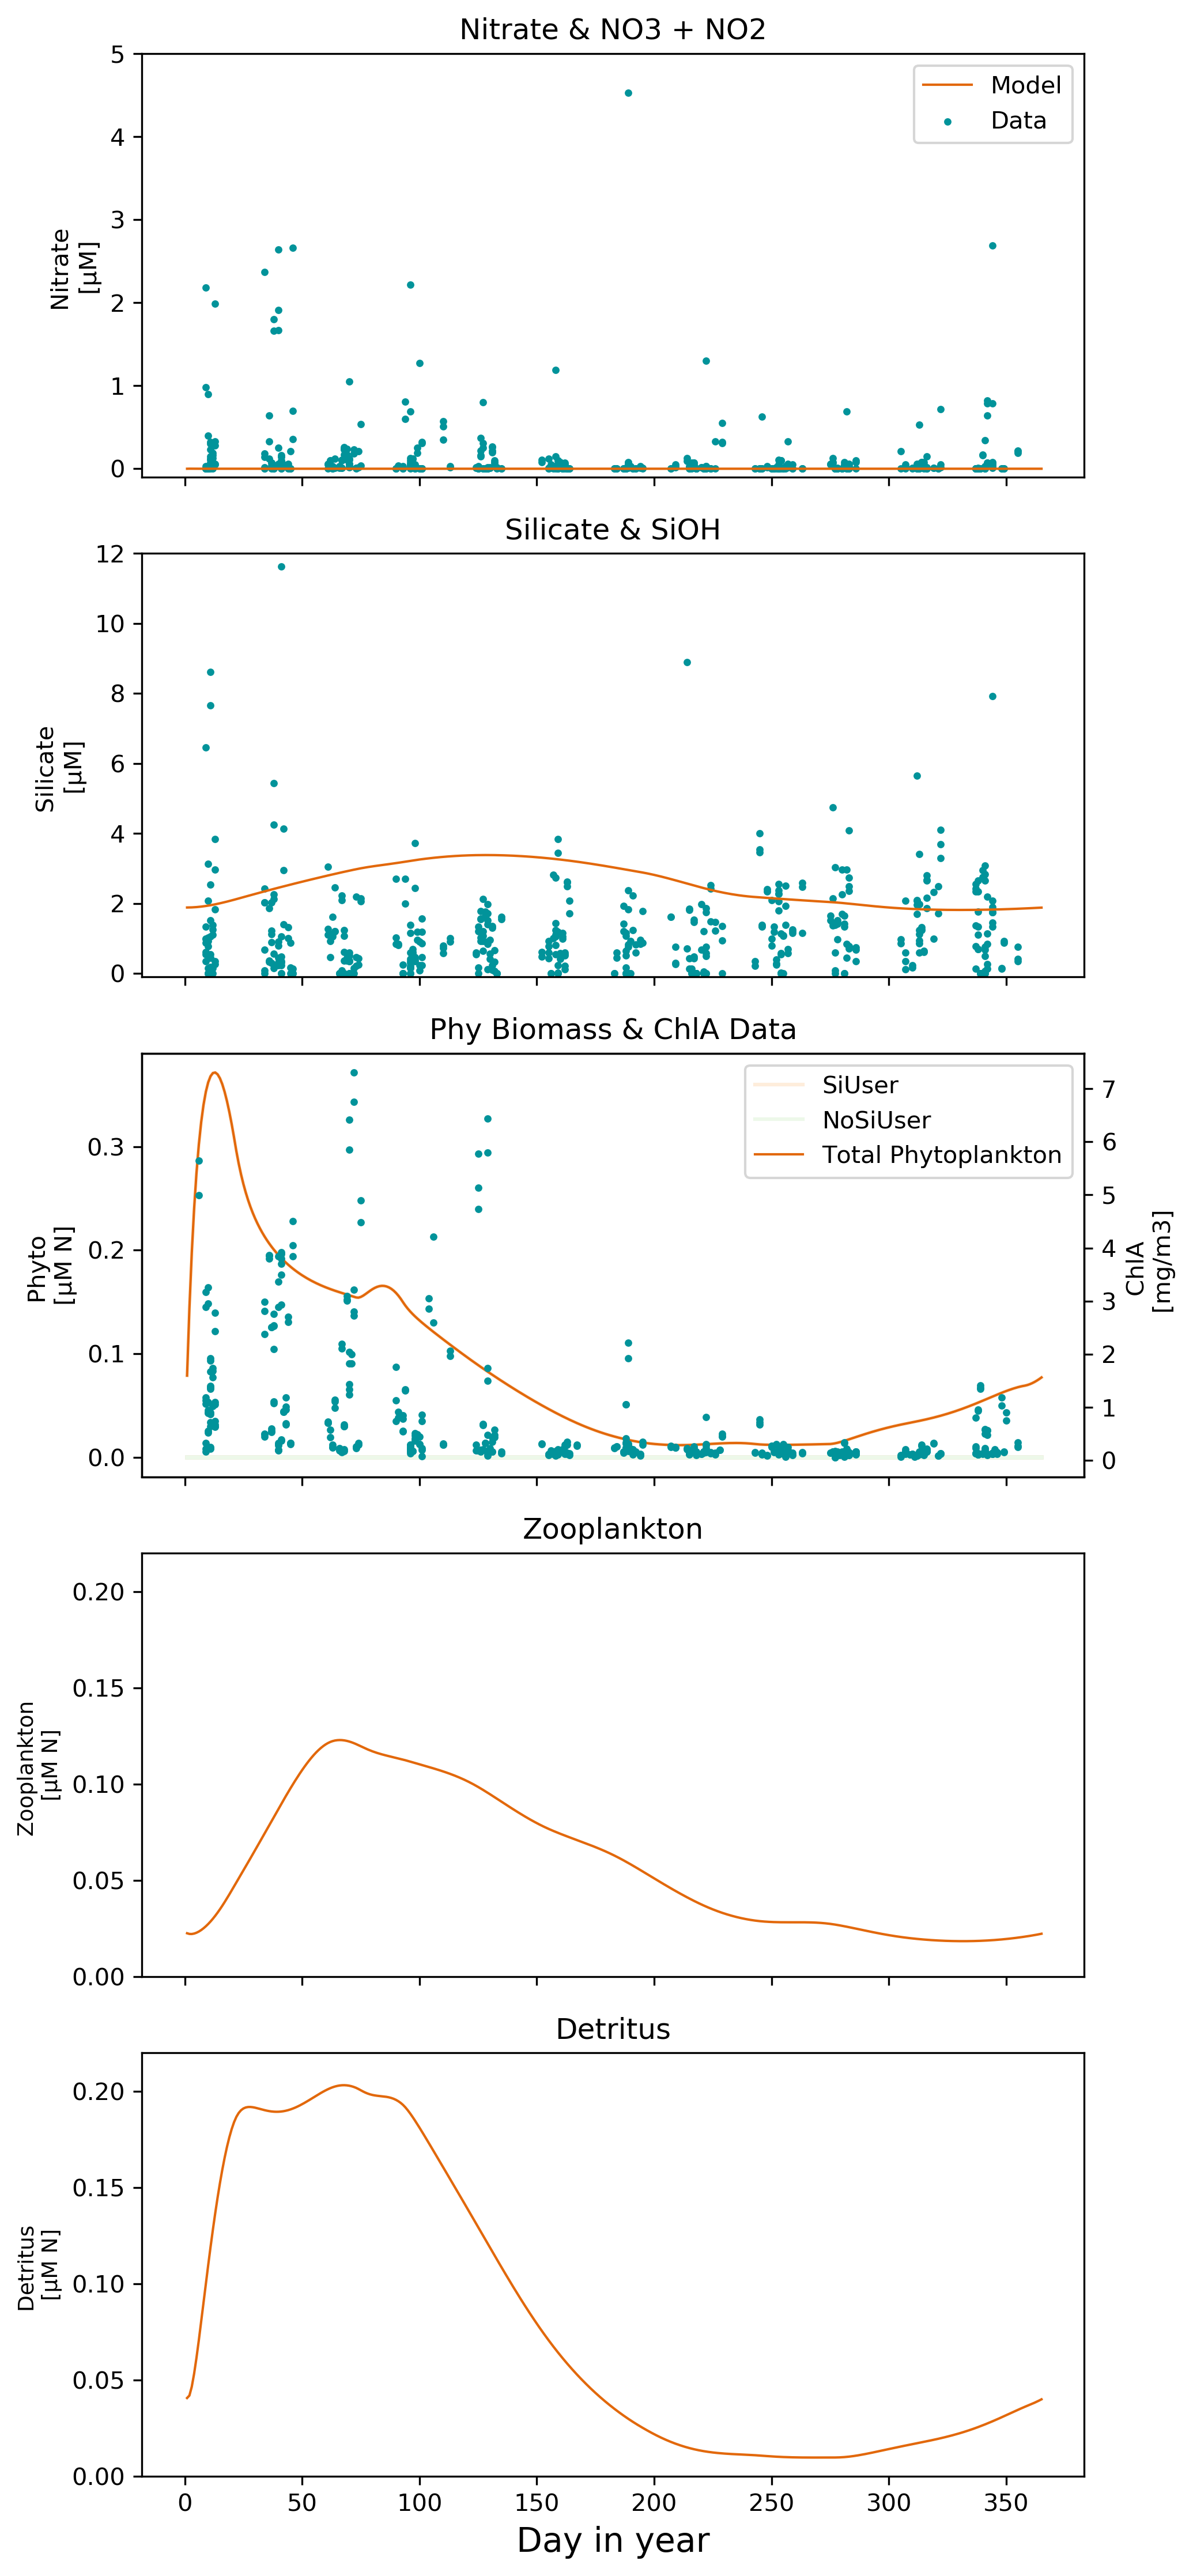

In [50]:
# Figure NO.2 SILICATE
f2, (ax1, axs1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex='col', sharey='row')
# N
ax1.plot(timedays, outarraySiNo[:, 0], c=colors[4], lw=lws[0], alpha=alphas[0], label='Model')
ax1.set_ylabel('Nitrate \n' '[µM]', multialignment='center', fontsize=10)
ax1.set_ylim(-0.1, 5)

#ax1.ticklabel_format(style='sci',scilimits=(0,0))

ax1.scatter(NO3NO2['yday'].values, NO3NO2['NO3NO2'].values, c=colors[1],s=4.3, label='Data')
ax1.set_title('Nitrate & NO3 + NO2')
ax1.legend(loc=1)

# Si
axs1.plot(timedays, outarraySiNo[:, 3+NoMtypeSi], c=colors[4], lw=lws[0], alpha=alphas[0])
axs1.set_ylabel('Silicate \n' '[µM]', multialignment='center', fontsize=10)
axs1.set_ylim(-0.1, 12)

axs1.scatter(SiOH_USF['yday'].values, SiOH_USF['SiOH'].values, c=colors[1],s=4.3)
axs1.set_title('Silicate & SiOH')

#NOW PLOT BOTH Phytoplankton together in one box
#PHYTO
for i in range(NoMtypeSi):
    ax2.plot(timedays, outarraySiNo[:, 3+i], c=orangescmapSi[1])

for i in range(NoMtypeNo):
    ax2.plot(timedays, outarraySiNo[:, 3+NoMtypeSi+1+i], c=orangescmapNo[1])

ax2.plot(0,0,c= orangescmapSi[1], label = 'SiUser') # just to include in legend / small hack
ax2.plot(0,0,c= orangescmapNo[1], label = 'NoSiUser') # just to include in legend / small hack

ax2.plot(timedays, ptot, c=colors[4], lw=lws[0], alpha=alphas[0], label='Total Phytoplankton')

ax2.set_ylabel('Phyto \n' '[µM N]', multialignment='center', fontsize=10)

ax2_tx = ax2.twinx()
ax2_tx.scatter(ChlA['yday'].values, ChlA['ChlA'].values, c=colors[1],s=4.3)
ax2_tx.set_ylabel('ChlA \n [mg/m3]')

ax2.set_title('Phy Biomass & ChlA Data')
ax2.legend()


# Z
ax3.plot(timedays, outarraySiNo[:, 1], c=colors[4], lw=lws[0], alpha=alphas[0])
ax3.set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=9)
ax3.tick_params('y', labelsize=10)

ax3.set_title('Zooplankton')
ax3.set_ylim(0, 0.22)

# D
ax4.plot(timedays, outarraySiNo[:, 2], c=colors[4], lw=lws[0], alpha=alphas[0])
ax4.set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)

ax4.set_title('Detritus')

ax4.set_xlabel('Day in year', fontsize=14)
ax4.set_ylim(0, 0.22)
# Legend


#plt.subplots_adjust(hspace=0.01)
f2.set_figheight(15)
plt.tight_layout()
plt.show()

In [30]:
mtypesSi_Full = outarraySiNo_Full[:, 3:3+NoMtypeSi]
mtypesNo_Full = outarraySiNo_Full[:, 3+NoMtypeSi+1:3+NoMtypeSi+1+NoMtypeNo]
ptotSi_Full = np.sum(mtypesSi_Full, 1)
ptotNo_Full = np.sum(mtypesNo_Full, 1)
ptot_Full = ptotNo_Full + ptotSi_Full

    
lmeanSi_Full = np.sum(mtypesSi_Full*sizerangeSi, 1)/ptotSi_Full
lvarSi_Full = np.sum(mtypesSi_Full*sizerangeSi**2, 1)/ptotSi_Full - lmeanSi_Full**2
lmeanNo_Full = np.sum(mtypesNo_Full*sizerangeNo, 1)/ptotNo_Full
lvarNo_Full = np.sum(mtypesNo_Full*sizerangeNo**2, 1)/ptotNo_Full - lmeanNo_Full**2

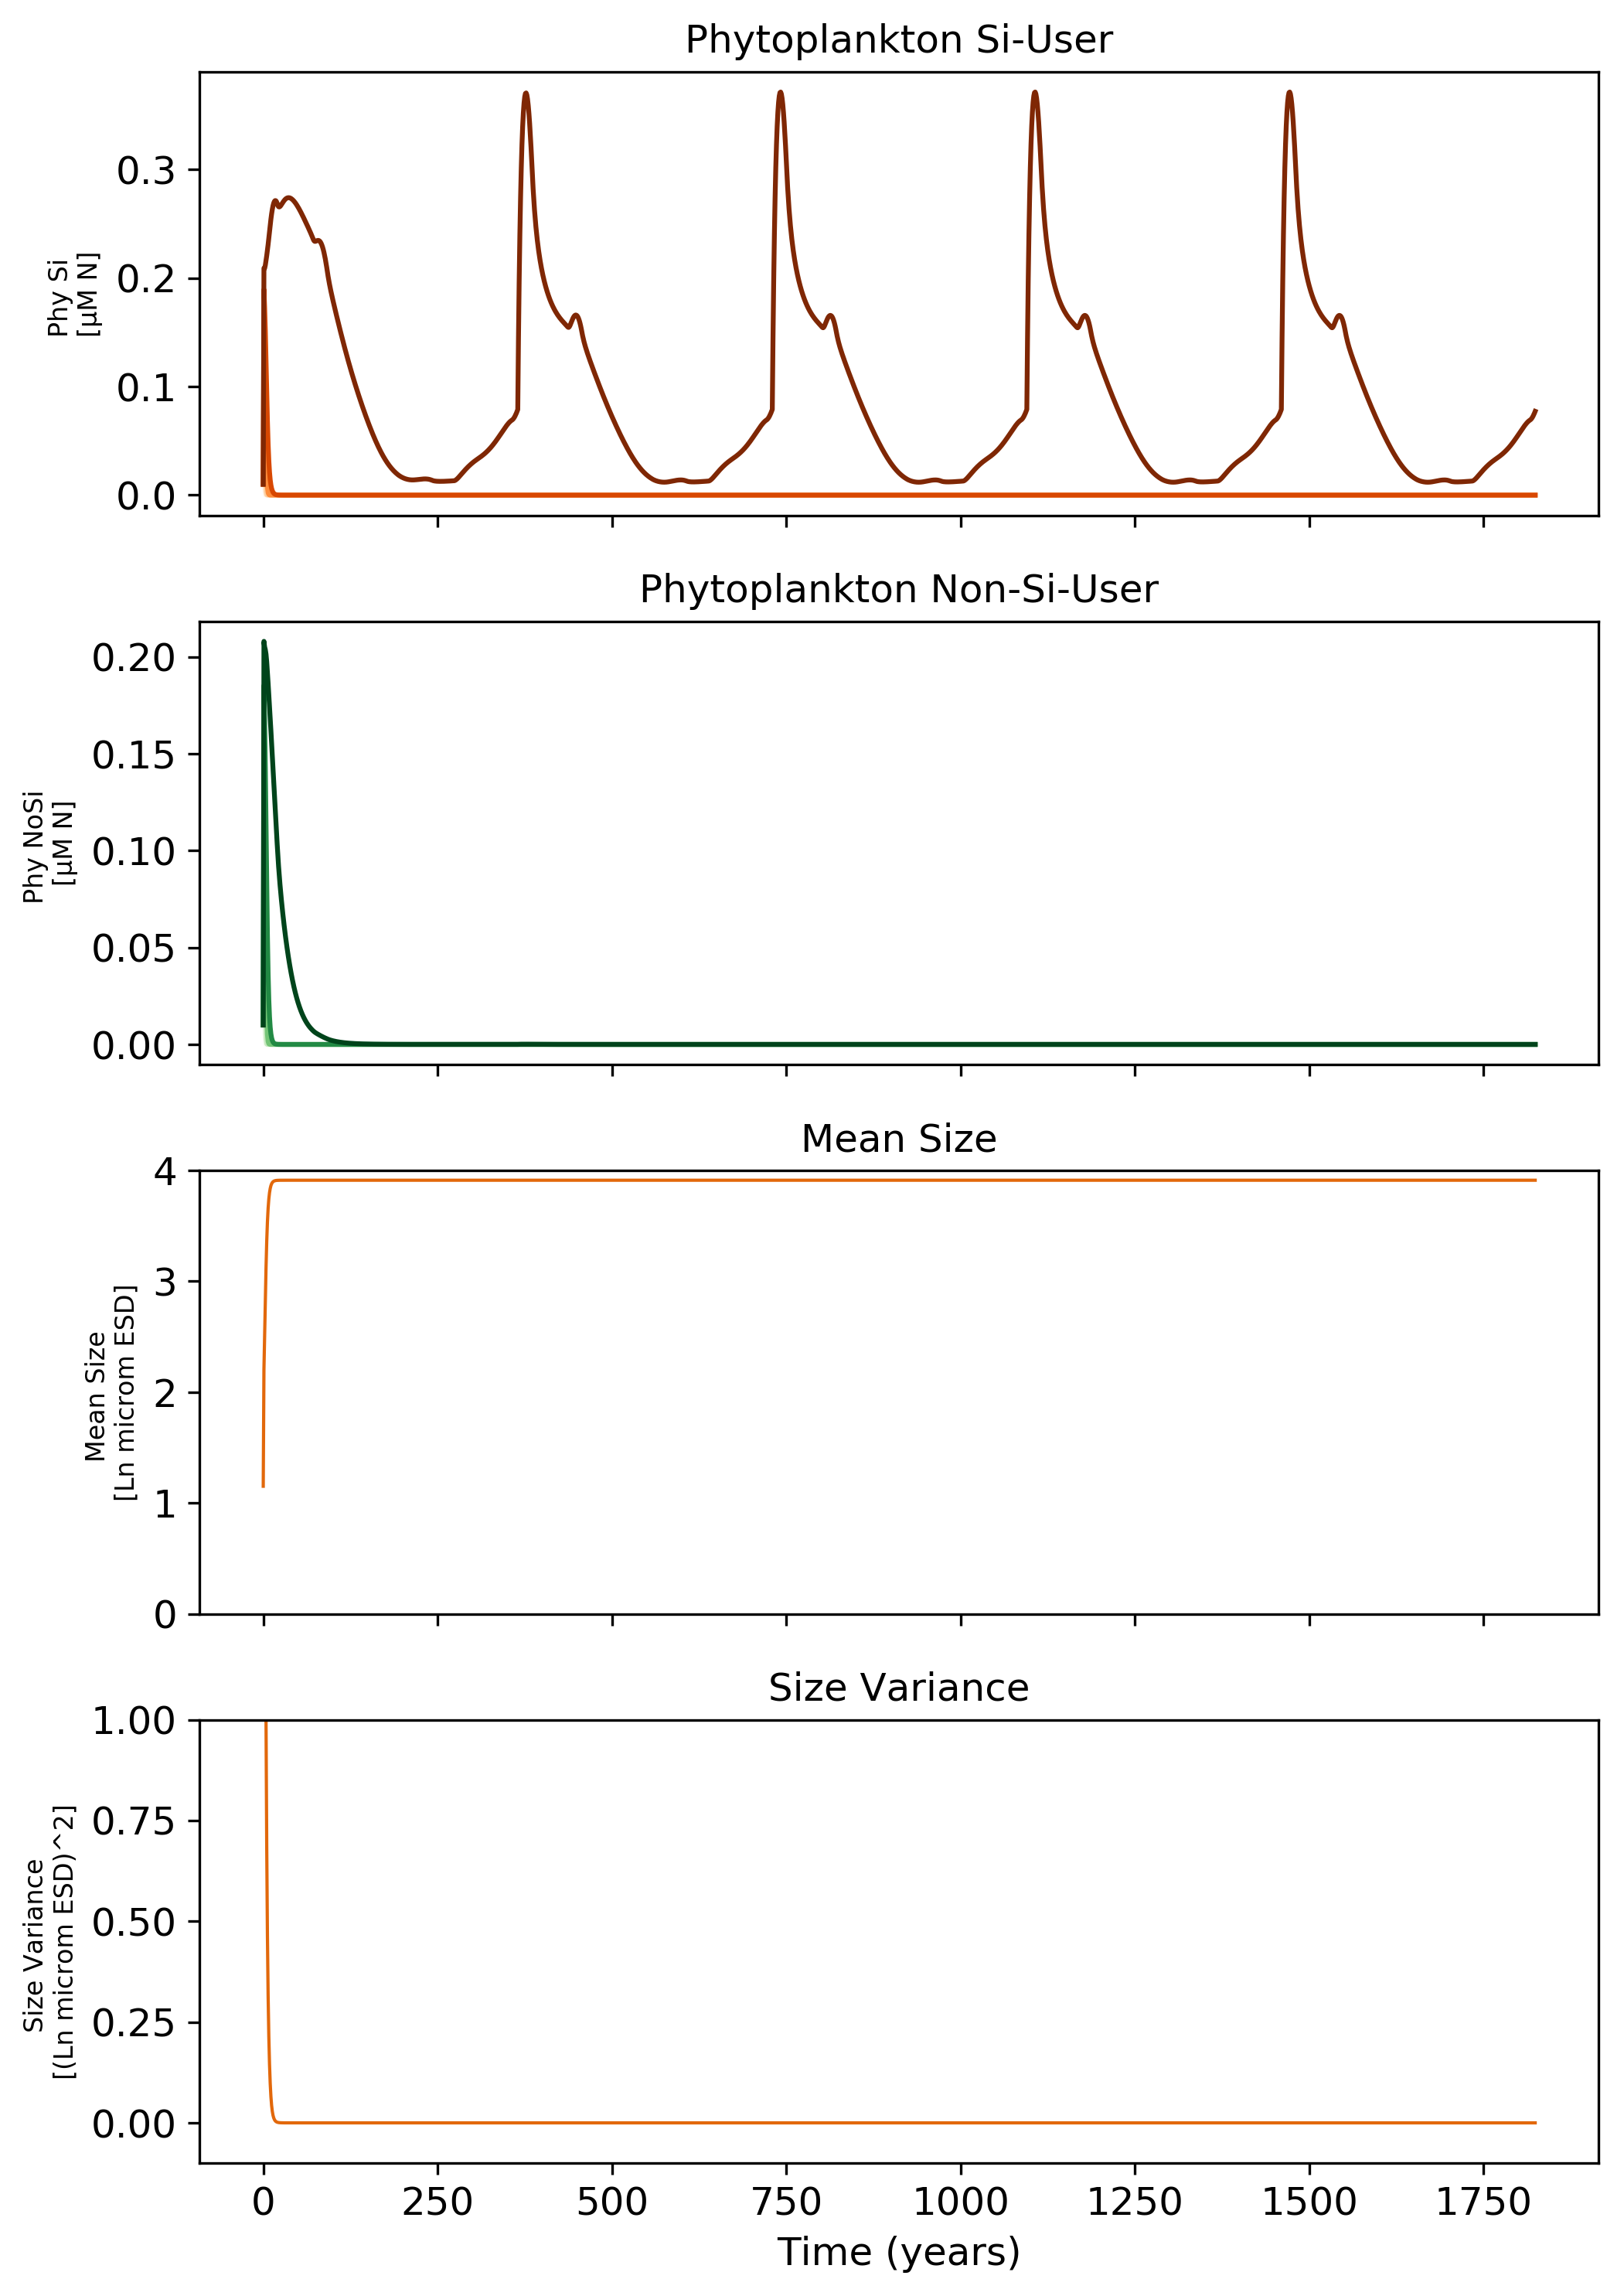

In [31]:
# Figure NO.3
f3, (ax1s, ax1, ax2, ax3) = plt.subplots(4, 1, sharex='col')
# Ps
for i in range(NoMtypeSi):
    ax1s.plot(timedays_model, outarraySiNo_Full[:, 3+i], c=orangescmapSi[i])
ax1s.set_ylabel('Phy Si \n' '[µM N]', multialignment='center', fontsize=8)
ax1s.tick_params('y', labelsize=12)
#ax1s.set_ylim(-0.1, 1)


ax1s.set_title('Phytoplankton Si-User')

# Pn
for i in range(NoMtypeNo):
    ax1.plot(timedays_model, outarraySiNo_Full[:, 3+NoMtypeSi+1+i], c=orangescmapNo[i])
ax1.set_ylabel('Phy NoSi \n' '[µM N]', multialignment='center', fontsize=8)
ax1.tick_params('y', labelsize=12)
#ax1.set_ylim(-0.1, 1)


ax1.set_title('Phytoplankton Non-Si-User')

# S
ax2.plot(timedays_model, lmeanSi_Full, c=colors[4], lw=lws[0], alpha=alphas[0])
ax2.set_ylabel('Mean Size \n' '[Ln microm ESD]', multialignment='center', fontsize=8)
ax2.set_ylim(0, 4)
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.tick_params('y', labelsize=12)


ax2.set_title('Mean Size')

# V
ax3.plot(timedays_model, lvarSi_Full, c=colors[4], lw=lws[0], alpha=alphas[0])
ax3.set_ylabel('Size Variance \n' '[(Ln microm ESD)^2]', multialignment='center', fontsize=8)
ax3.set_xlabel(r'Time (years)', fontsize=12)
ax3.tick_params('both', labelsize=12)
ax3.set_ylim(-0.1,1)


ax3.set_title('Size Variance')

f3.set_figheight(10)
# Legend
plt.tight_layout()

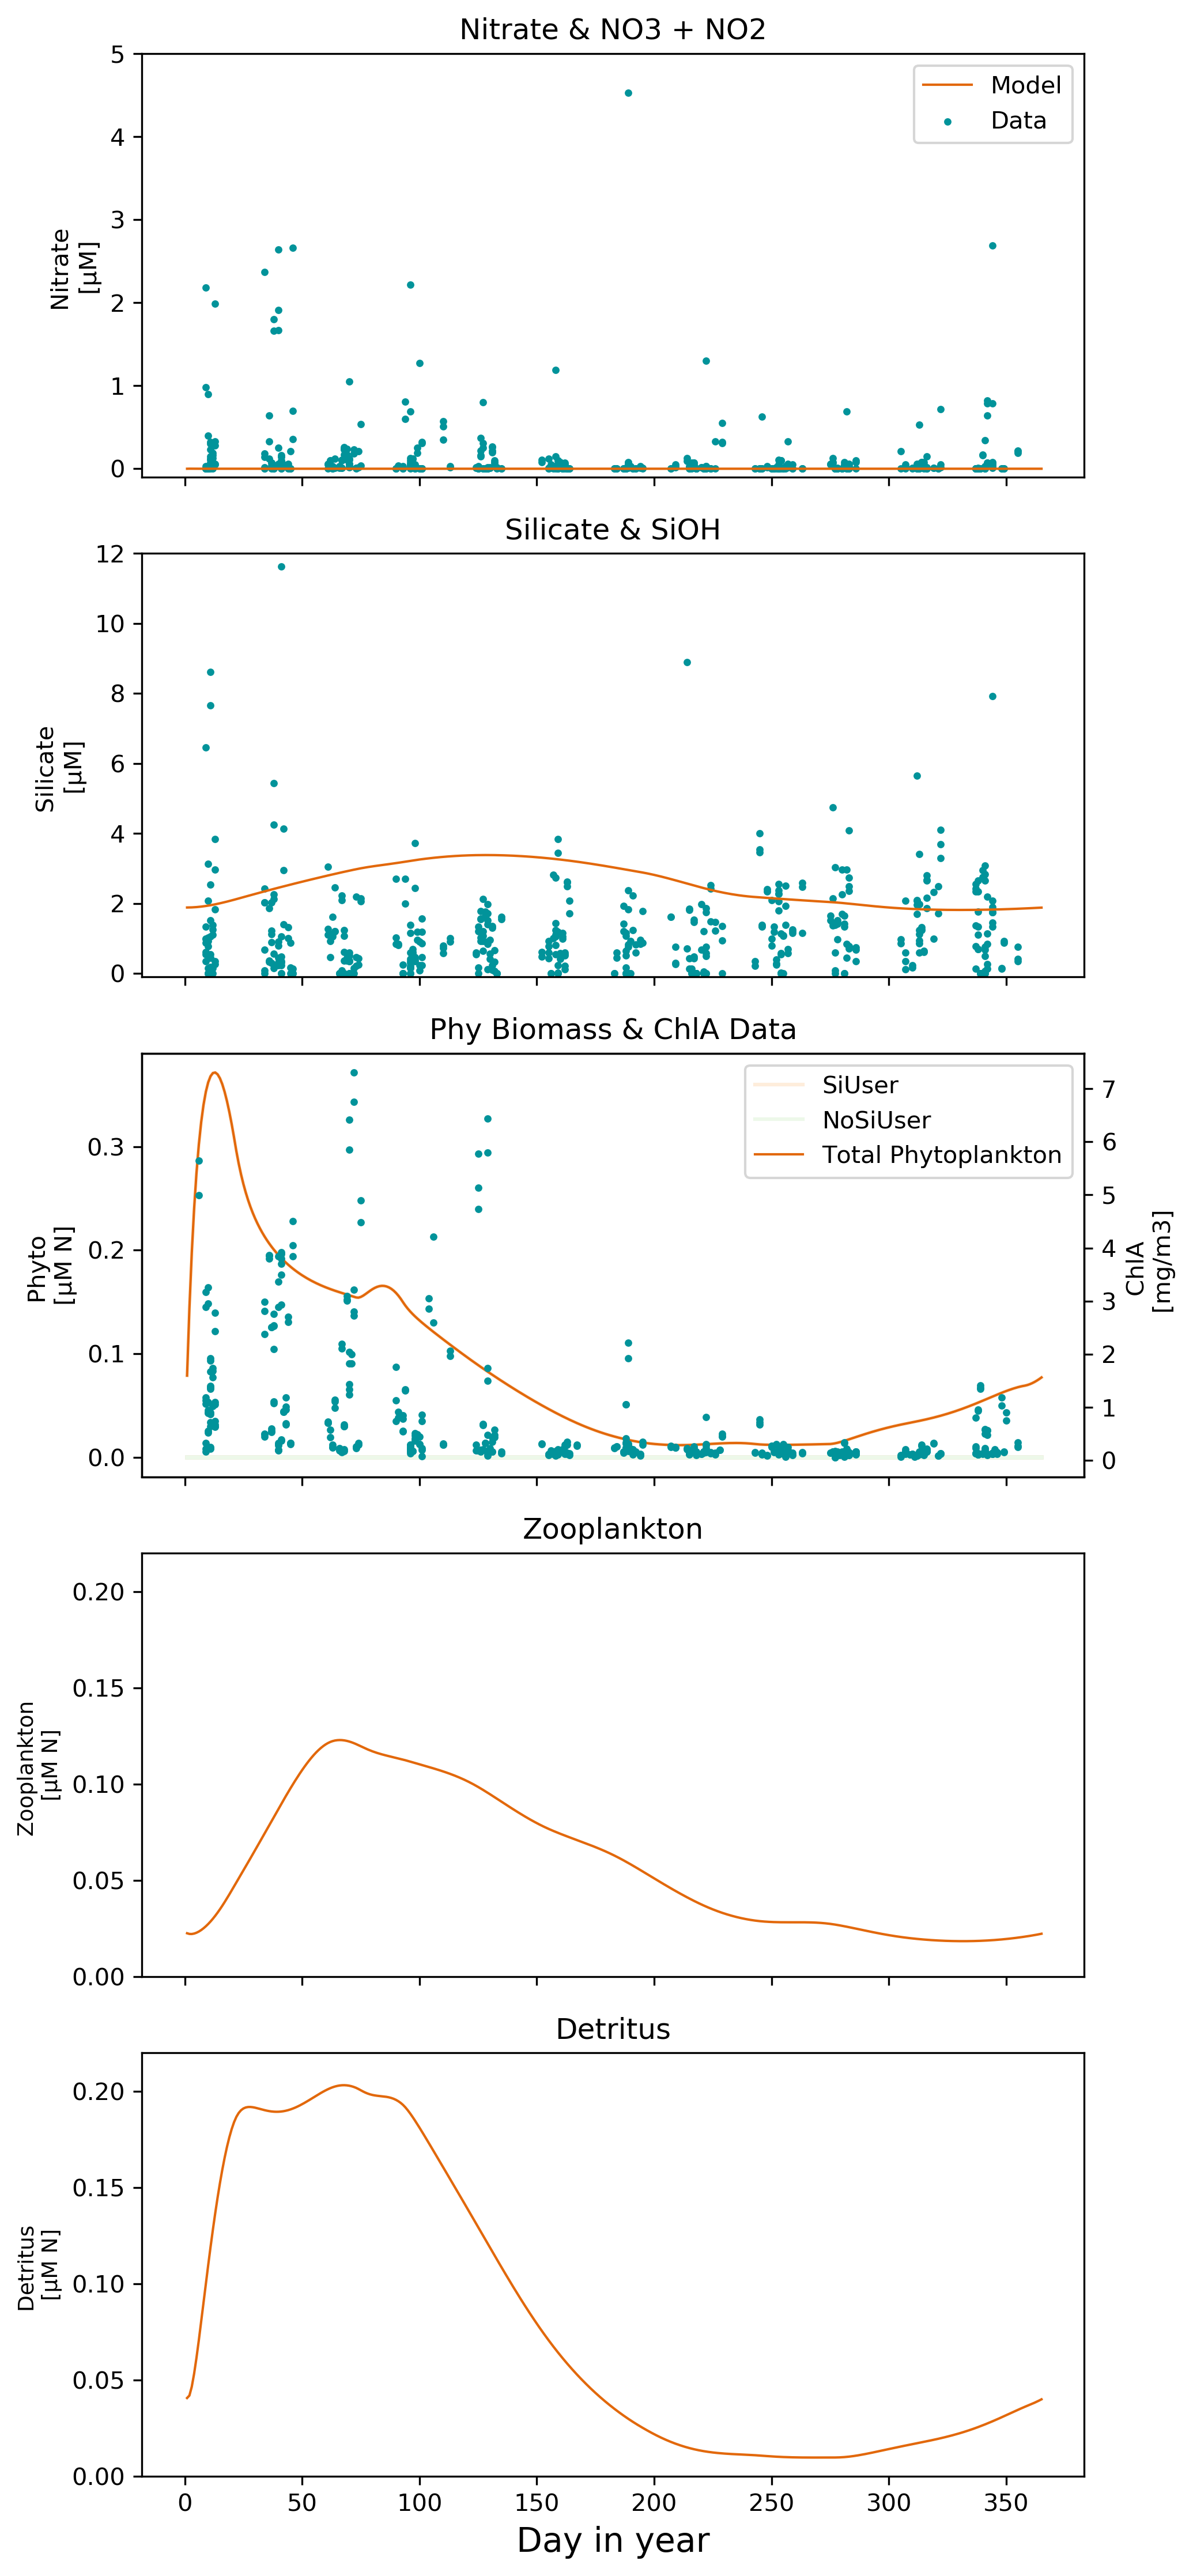

In [42]:
# Figure NO.2 SILICATE
f2, (ax1, axs1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex='col', sharey='row')
# N
ax1.plot(timedays, outarraySiNo[:, 0], c=colors[4], lw=lws[0], alpha=alphas[0], label='Model')
ax1.set_ylabel('Nitrate \n' '[µM]', multialignment='center', fontsize=10)
ax1.set_ylim(-0.1, 5)

#ax1.ticklabel_format(style='sci',scilimits=(0,0))

ax1.scatter(NO3NO2['yday'].values, NO3NO2['NO3NO2'].values, c=colors[1],s=4.3, label='Data')
ax1.set_title('Nitrate & NO3 + NO2')
ax1.legend(loc=1)

# Si
axs1.plot(timedays, outarraySiNo[:, 3+NoMtypeSi], c=colors[4], lw=lws[0], alpha=alphas[0])
axs1.set_ylabel('Silicate \n' '[µM]', multialignment='center', fontsize=10)
axs1.set_ylim(-0.1, 12)

axs1.scatter(SiOH_USF['yday'].values, SiOH_USF['SiOH'].values, c=colors[1],s=4.3)
axs1.set_title('Silicate & SiOH')

#NOW PLOT BOTH Phytoplankton together in one box
#PHYTO
for i in range(NoMtypeSi):
    ax2.plot(timedays, outarraySiNo[:, 3+i], c=orangescmapSi[1])

for i in range(NoMtypeNo):
    ax2.plot(timedays, outarraySiNo[:, 3+NoMtypeSi+1+i], c=orangescmapNo[1])

ax2.plot(0,0,c= orangescmapSi[1], label = 'SiUser') # just to include in legend / small hack
ax2.plot(0,0,c= orangescmapNo[1], label = 'NoSiUser') # just to include in legend / small hack

ax2.plot(timedays, ptot, c=colors[4], lw=lws[0], alpha=alphas[0], label='Total Phytoplankton')

ax2.set_ylabel('Phyto \n' '[µM N]', multialignment='center', fontsize=10)

ax2_tx = ax2.twinx()
ax2_tx.scatter(ChlA['yday'].values, ChlA['ChlA'].values, c=colors[1],s=4.3)
ax2_tx.set_ylabel('ChlA \n [mg/m3]')

ax2.set_title('Phy Biomass & ChlA Data')
ax2.legend()


# Z
ax3.plot(timedays, outarraySiNo[:, 1], c=colors[4], lw=lws[0], alpha=alphas[0])
ax3.set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=9)
ax3.tick_params('y', labelsize=10)

ax3.set_title('Zooplankton')
ax3.set_ylim(0, 0.22)

# D
ax4.plot(timedays, outarraySiNo[:, 2], c=colors[4], lw=lws[0], alpha=alphas[0])
ax4.set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)

ax4.set_title('Detritus')

ax4.set_xlabel('Day in year', fontsize=14)
ax4.set_ylim(0, 0.22)
# Legend


#plt.subplots_adjust(hspace=0.01)
f2.set_figheight(15)
plt.tight_layout()
plt.show()

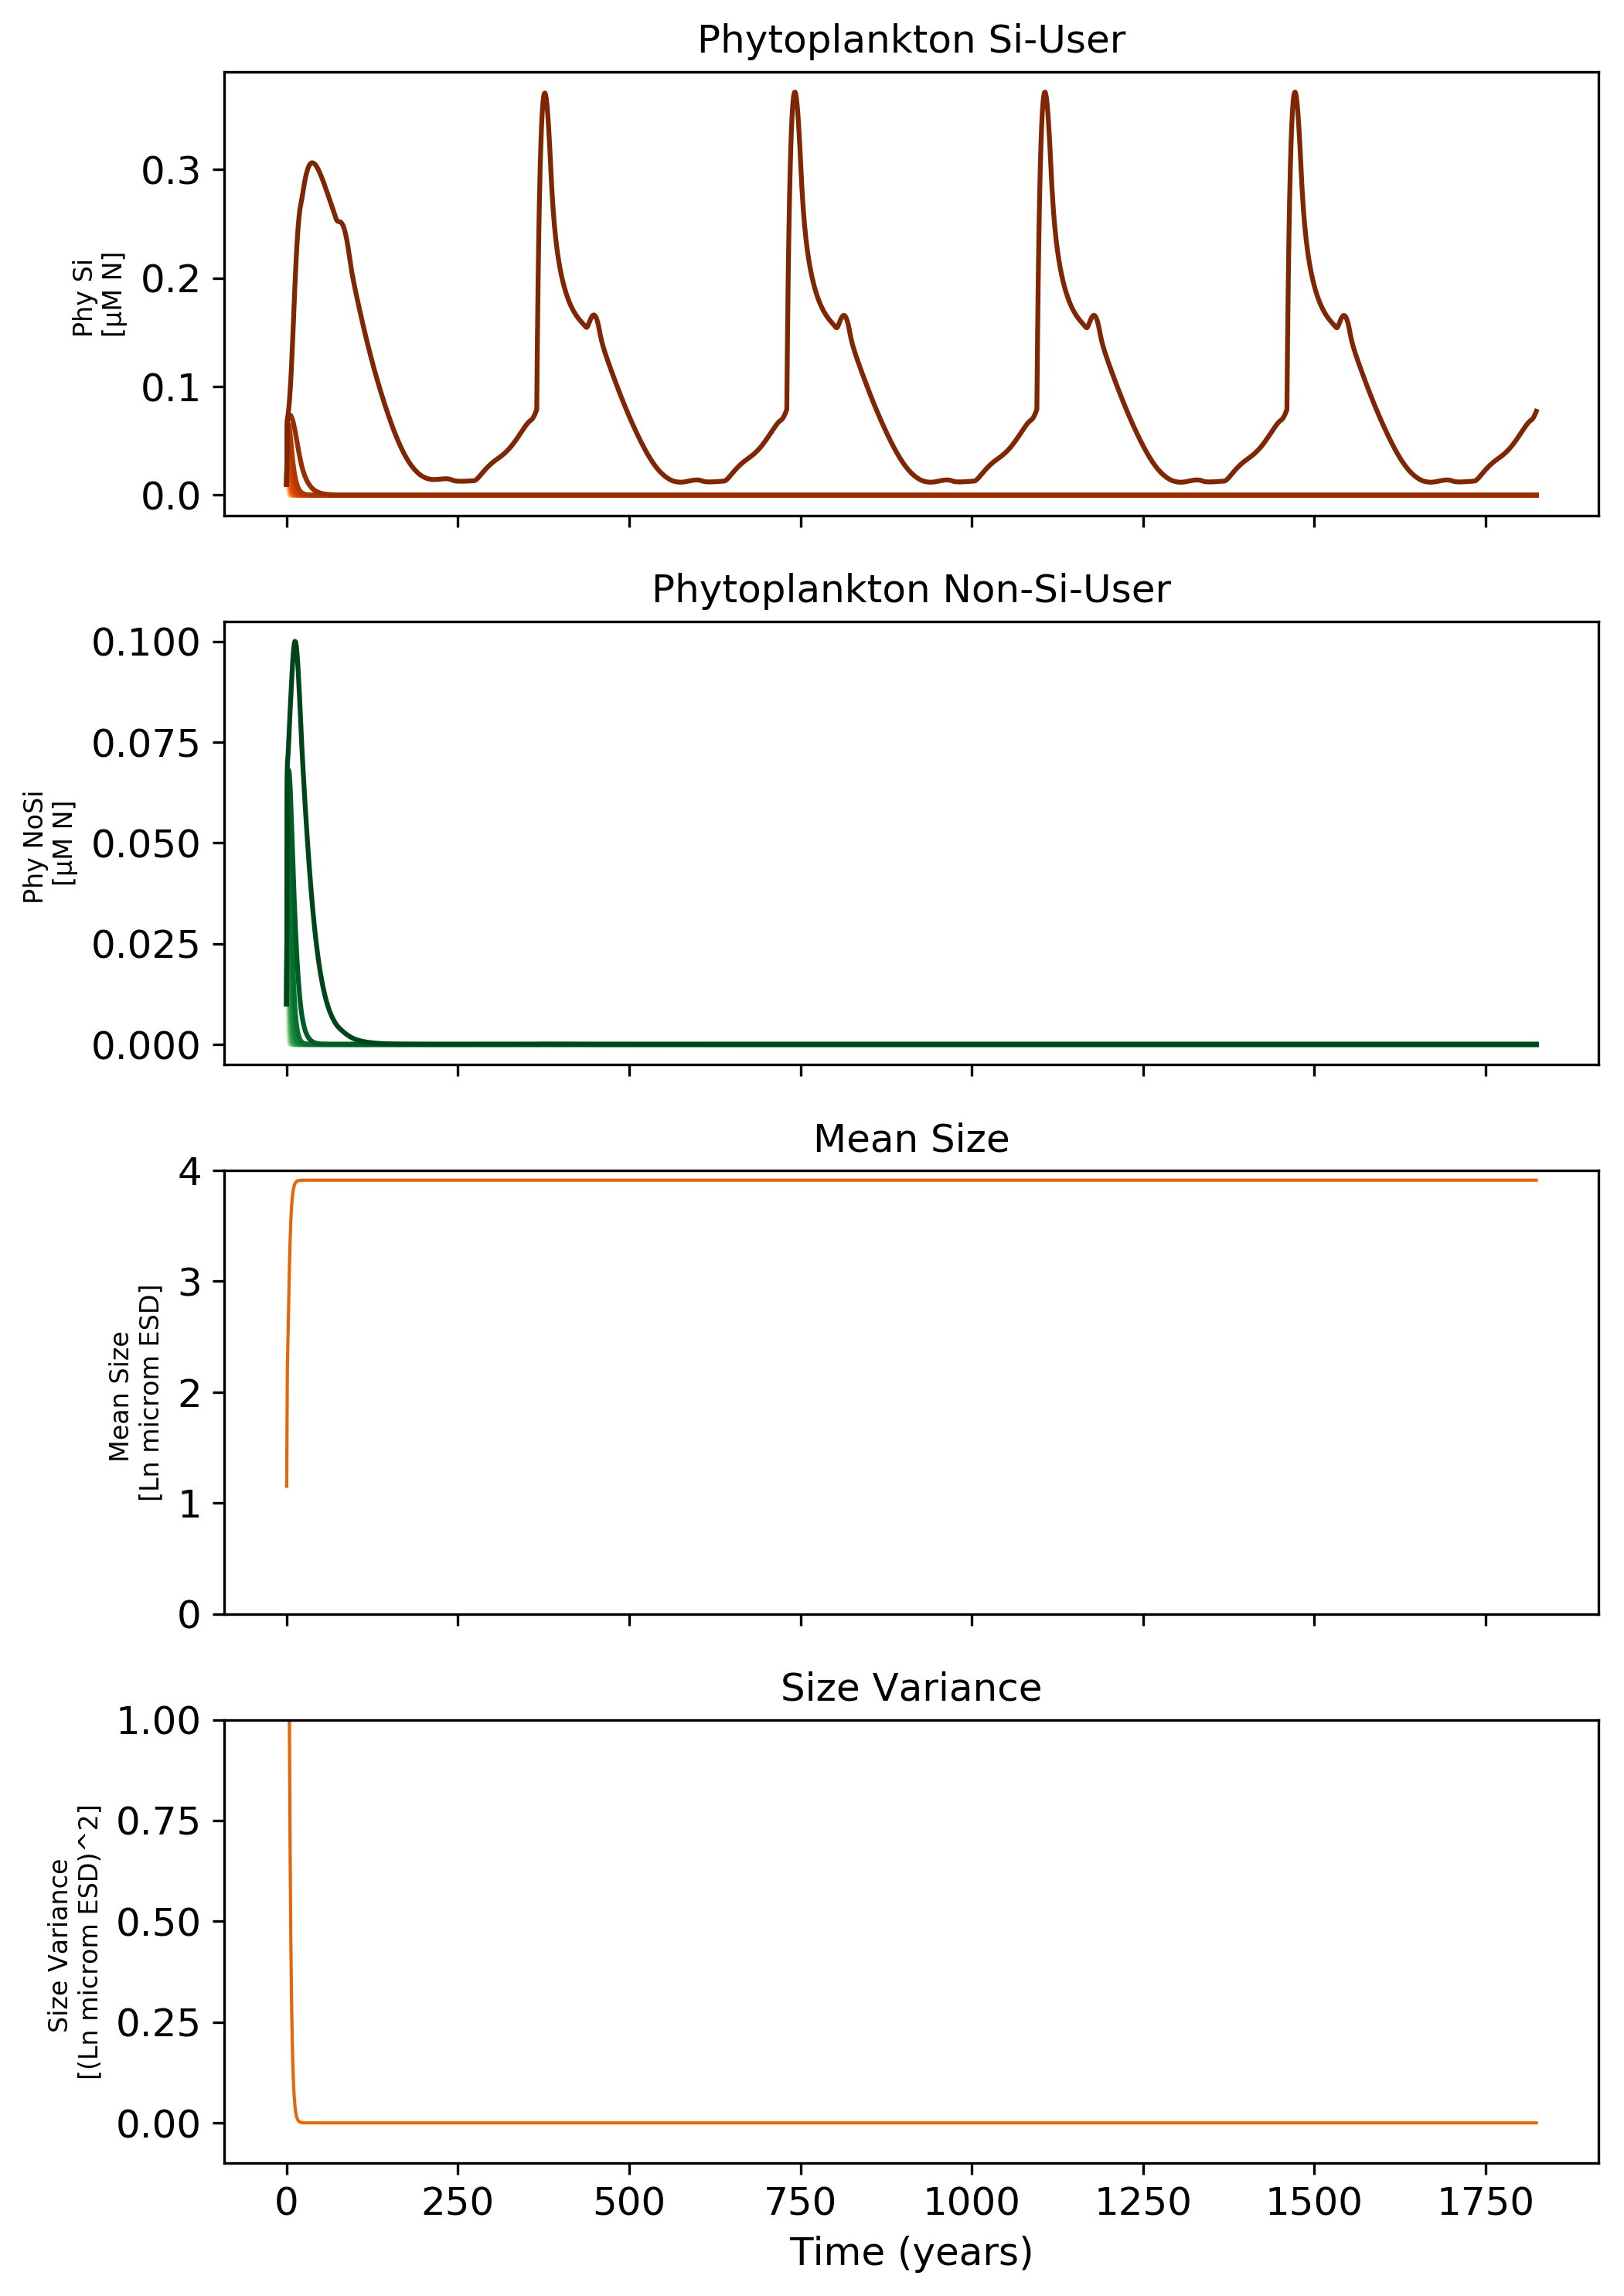

In [43]:
# Figure NO.3
f3, (ax1s, ax1, ax2, ax3) = plt.subplots(4, 1, sharex='col')
# Ps
for i in range(NoMtypeSi):
    ax1s.plot(timedays_model, outarraySiNo_Full[:, 3+i], c=orangescmapSi[i])
ax1s.set_ylabel('Phy Si \n' '[µM N]', multialignment='center', fontsize=8)
ax1s.tick_params('y', labelsize=12)
#ax1s.set_ylim(-0.1, 1)


ax1s.set_title('Phytoplankton Si-User')

# Pn
for i in range(NoMtypeNo):
    ax1.plot(timedays_model, outarraySiNo_Full[:, 3+NoMtypeSi+1+i], c=orangescmapNo[i])
ax1.set_ylabel('Phy NoSi \n' '[µM N]', multialignment='center', fontsize=8)
ax1.tick_params('y', labelsize=12)
#ax1.set_ylim(-0.1, 1)


ax1.set_title('Phytoplankton Non-Si-User')

# S
ax2.plot(timedays_model, lmeanSi_Full, c=colors[4], lw=lws[0], alpha=alphas[0])
ax2.set_ylabel('Mean Size \n' '[Ln microm ESD]', multialignment='center', fontsize=8)
ax2.set_ylim(0, 4)
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.tick_params('y', labelsize=12)


ax2.set_title('Mean Size')

# V
ax3.plot(timedays_model, lvarSi_Full, c=colors[4], lw=lws[0], alpha=alphas[0])
ax3.set_ylabel('Size Variance \n' '[(Ln microm ESD)^2]', multialignment='center', fontsize=8)
ax3.set_xlabel(r'Time (years)', fontsize=12)
ax3.tick_params('both', labelsize=12)
ax3.set_ylim(-0.1,1)


ax3.set_title('Size Variance')

f3.set_figheight(10)
# Legend
plt.tight_layout()